In [221]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import scipy.sparse.linalg as sla
from scipy.linalg import eig
from tqdm import tqdm
import pickle 
from pfapack import pfaffian as pf
from scipy.fft import ifftn
import dask.array as da
import scipy.integrate as integrate
from scipy.integrate import quad
from matplotlib.colors import ListedColormap
from scipy.linalg import expm

In [197]:
def S2(k):
    S2=np.sqrt(2)*np.sqrt(np.cosh(G)+1)*np.tanh(G/2)*((1/np.cosh(G/2))**(3))*np.sin(k)*np.cos(k)*(1+1j*np.sinh(G/2)*np.sin(k)) + eta*np.cos(3*k)  #checked
    return S2

In [199]:
def S1(k):   
    S1=-0.5*np.cosh(G/2)*((1/np.cosh(G/2))**(4))*np.sin(k)*(-np.cosh(G)*np.cos(2*k)+np.cos(2*k)+2) - eta*np.sin(3*k)
    return S1#checked

In [198]:
np.allclose(S2(-k).conj(),-S2(k))

True

In [272]:
#coefficients check

k,A,G=1,1,1
eps1,eps2,d=0,0,0

N1=((1/np.cosh(G/2))**(4))*(-8*np.cosh(G/2)**(3)-4*np.sinh(G/2)**(2)*np.cos(3*k)+2*(3*np.cosh(G)+1)*np.cos(k))/(8*A) -((eps1+eps2)/2)+d*np.cos(3*k)#checked
N2=(-((1/np.cosh(G/2))**(4))/(4*A))*(4*np.cosh(G/2)**(3)-2*np.sinh(G/2)**(2)*np.cos(3*k)+3*np.cosh(G)*np.cos(k)+np.cos(k)) -(eps1+eps2)/2-d*np.cos(3*k) #checked
Hm=-np.tanh(G/2)*((1/np.cosh(G/2))**(3)*(np.cosh(G)+4*1j*np.sinh(G/2)*np.sin(k)**(3)+2*np.cos(2*k)-1))/(2*A) + (eps1-eps2)/2-1j*d*np.sin(3*k)#checked
S1=-0.5*np.cosh(G/2)*((1/np.cosh(G/2))**(4))*np.sin(k)*(-np.cosh(G)*np.cos(2*k)+np.cos(2*k)+2) - eta*np.sin(3*k) #checked
S2=np.sqrt(2)*np.sqrt(np.cosh(G)+1)*np.tanh(G/2)*((1/np.cosh(G/2))**(3))*np.sin(k)*np.cos(k)*(1+1j*np.sinh(G/2)*np.sin(k)) + eta*np.cos(3*k)  #checked
print("N1=",N1,"N2=",N2,"Hm=",Hm,"S1=",S1,"S2=",S2)

N1= -0.3333946170528934 N2= -1.4402431508872549 Hm= (0.04660631462290702-0.20013427994951674j) S1= -0.6531897459686514 S2= (0.3304668646647564+0.1449052852546782j)


In [298]:
#Define Hamiltonian, choose random k value, evaluate for A, G and test if PH operator sigmax cross sigmax flips its sign
def Na(a,g):
    return (4*np.exp(g/2)*(1+3*np.exp(2*g)))/((1+np.exp(g))**(4)*a)

def Nb(a,g):
    return (4*np.exp(3*g/2)*(3+np.exp(2*g)))/((1+np.exp(g))**(4)*a)


def H(k,A,G,eps1,eps2,d,eta):
    

    N1=((1/np.cosh(G/2))**(4))*(-8*np.cosh(G/2)**(3)-4*np.sinh(G/2)**(2)*np.cos(3*k)+2*(3*np.cosh(G)+1)*np.cos(k))/(8*A) -(eps1+eps2)/2+d*np.cos(3*k)#checked
    N2=(-((1/np.cosh(G/2))**(4))/(4*A))*(4*np.cosh(G/2)**(3)-2*np.sinh(G/2)**(2)*np.cos(3*k)+3*np.cosh(G)*np.cos(k)+np.cos(k)) -(eps1+eps2)/2-d*np.cos(3*k) #checked
    Hm=-np.tanh(G/2)*((1/np.cosh(G/2))**(3)*(np.cosh(G)+4*1j*np.sinh(G/2)*np.sin(k)**(3)+2*np.cos(2*k)-1))/(2*A) + (eps1-eps2)/2-1j*d*np.sin(3*k)#checked
    S1=-0.5*np.cosh(G/2)*((1/np.cosh(G/2))**(4))*np.sin(k)*(-np.cosh(G)*np.cos(2*k)+np.cos(2*k)+2) - eta*np.sin(3*k) #checked
    S2=np.sqrt(2)*np.sqrt(np.cosh(G)+1)*np.tanh(G/2)*((1/np.cosh(G/2))**(3))*np.sin(k)*np.cos(k)*(1+1j*np.sinh(G/2)*np.sin(k)) + 1j*eta*np.cos(3*k)  #checked
    
    
    
    H = np.zeros((4,4), dtype=complex)
    H[0,0]=N1      
    H[0,1]=Hm      #+1j*d*np.sin(3*k)
    H[0,2]=S1 
    H[0,3]=S2 
    H[1,0]=Hm.conj()#    -1j*d*np.sin(3*k)
    H[1,1]=N2      
    H[1,2]=S2.conj()
    H[1,3]=-S1
    H[2,0]=S1
    H[2,1]=S2  #NORMALLY S2
    H[2,2]=-N1      #-eps1-d*np.cos(3*k)
    H[2,3]=-Hm      #-1j*d*np.sin(3*k)
    H[3,0]=S2.conj()  #NORMALLY S2.conj()
    H[3,1]=-S1
    H[3,2]=-Hm.conj()#          +1j*d*np.sin(3*k)
    H[3,3]=-N2        #   -eps2-d*np.cos(3*k)
    
    return(H)

def magical(k,A,G,eps1,eps2,d,eta):
    #magic Unitary
    U = np.array([[1,1],[1j,-1j]], dtype='complex128')
    U = np.kron(U,np.eye(2))
    magic = (1/2)*(U@U)
    return (magic@H(k,A,G,eps1,eps2,d,eta)@magic.conj().T)[2:,:2]

id=np.array([[1,0],[0,1]])
sigma_x=np.array([[0,1],[1,0]])
sigma_y=np.array([[0,-1j],[1j,0]])
sigma_z=np.array([[1,0],[0,-1]])



def complex_quadrature(func, a, b, **kwargs):
    def real_func(x):
        return np.real(func(x))
    def imag_func(x):
        return np.imag(func(x))
    real_integral = quad(real_func, a, b,limit=200)
    imag_integral = quad(imag_func, a, b,limit=200)
    return ((real_integral[0] + 1j*imag_integral[0]))

def integrand(k, a, g,eps1,eps2,d,eta):
    k_res=0.0001
    inv = (np.linalg.inv(magical(k,a,g,eps1,eps2,d,eta)))
    der = (1/(2*k_res))*(magical(k+k_res,a,g,eps1,eps2,d,eta)-magical(k-k_res,a,g,eps1,eps2,d,eta))
    temp = inv@der
    return np.trace(temp)

In [289]:
k,A,G,eps1,eps2,d,eta=1,1,1,0,0,0,0
eigvals,_=np.linalg.eigh(H(k,A,G,eps1,eps2,d,eta))
print(magical(k,A,G,eps1,eps2,d,eta)[:2,2:]-magical(k,A,G,eps1,eps2,d,eta)[2:,:2].conj().T)

[]


In [290]:
H(k,A,G,eps1,eps2,d,eta)-H(-k,A,G,eps1,eps2,d,eta)

array([[ 0.        +0.j        ,  0.        -0.40026856j,
        -1.30637949+0.j        ,  0.66093373+0.j        ],
       [ 0.        +0.40026856j,  0.        +0.j        ,
         0.66093373+0.j        ,  1.30637949+0.j        ],
       [-1.30637949+0.j        ,  0.66093373+0.j        ,
         0.        +0.j        ,  0.        +0.40026856j],
       [ 0.66093373+0.j        ,  1.30637949+0.j        ,
         0.        -0.40026856j,  0.        +0.j        ]])

In [291]:
#SYMMETRIES
C1 = 1j*np.kron(sigma_z, np.eye(2))
C1bis=np.eye(4)
C2= np.kron(sigma_x,np.eye(2))
Sub = np.kron(np.eye(2),sigma_z)
C3=C2@C1
a,g=1,1
eps,d,eta=0,0,0
#verify commutation relations 
#time reversal
print('Time reversal C1 is',np.allclose(C1@H(1,a,g,eps,-eps,d,eta).conj()@np.linalg.inv(C1),H(-1,a,g,eps,-eps,d,eta)))

#PH symmetry
print('PH C2 is',np.allclose(C2@np.conj(H(0.1,a,g,eps,-eps,d,eta))@np.linalg.inv(C2),-H(-0.1,a,g,eps,-eps,d,eta)))

#Chiral
print('Mysterious chiral C3=C2C1 is',np.allclose(C3@H(0.1,a,g,eps,-eps,d,eta)@np.linalg.inv(C3),-H(0.1,a,g,eps,-eps,d,eta)))


Time reversal C1 is True
PH C2 is True
Mysterious chiral C3=C2C1 is True


In [61]:
#hermiticity check
eps,d,eta=0,0,0
np.allclose(H(1,1,1,eps,eps,d,eta).conj().T-H(1,1,1,eps,eps,d,eta),0*np.eye(4))

True

In [62]:
#unitarity check (not expected in BdG basis)
np.allclose(H(1,1,1,0,0,0,0)@H(1,1,1,0,0,0,0).conj().T,np.eye(4))

False

In [63]:
#verify if U2@C2@U2=sigma_z
U = np.array([[1,1],[1j,-1j]], dtype='complex128')
U = np.kron(U,np.eye(2))
magic = (1/2)*(U@U)
magic@C2@magic.conj().T

array([[0.+0.j, 0.+0.j, 0.-1.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.-1.j],
       [0.+1.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+1.j, 0.+0.j, 0.+0.j]])

In [342]:
#integrator chiral index

k_res=0.001
par_res=0.002
eps_range = np.arange(0.31,-0.3,-par_res)
d_range = np.arange(-0.3,0.31,par_res) 
k_range = np.arange(-np.pi, np.pi, k_res)
#trying original formula 
A2 = np.zeros((len(eps_range),len(d_range)), dtype='c16')


eta=0
a,g=5,3
for m,eps in enumerate(tqdm(eps_range)):
    
    for n,d in enumerate(d_range):
        
        try:
            # Attempt to evaluate the integral
            v_tot = complex_quadrature(lambda k: integrand(k,a,g,eps,-eps,d,eta), -np.pi/2, np.pi/2)

            # Normalize the result
            v_tot = (1 / (2 * np.pi * 1j)) * v_tot

            # Store the result in the matrix
            A2[m, n] = v_tot

        except Exception as e:
            # Handle the exception (e.g., matrix is singular, integral diverges)
            print(f"Integration failed for ({eps}, {d}): {e}")
            
            # Assign a specific value to A1[m, n] when integration fails
            A2[m, n] = 13  # You can replace np.nan with any other value

# #saving data
with open('DEF eps vs delta,eps1=eps2,a='+str(a)+'g='+str(g)+'par_res='+str(par_res)+'.pkl', 'wb') as file:
        
    # A new file will be created
    pickle.dump(A2, file)   
#    



  0%|                                                                                           | 0/305 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [308]:
with open('DEF eps vs delta,eps1=-eps2,a='+str(a)+'g='+str(g)+'par_res='+str(par_res)+'.pkl', 'wb') as file:
        
    # A new file will be created
    pickle.dump(A2, file)   

Text(0, 0.5, '$\\epsilon$')

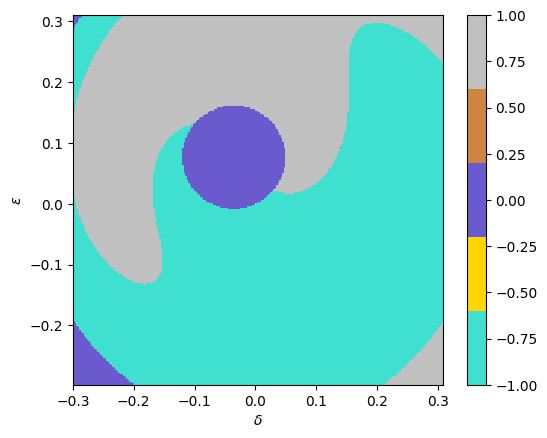

In [307]:
csfont = {'fontname':'Serif'}

x,y = d_range,eps_range
grid=np.real(A2)

# Create a new figure and add a subplot
fig, ax = plt.subplots()
# Define colors manually
colors = ['turquoise','gold','slateblue','peru','silver']  # Add more colors as needed

# Create a ListedColormap with the specified colors
cmap = ListedColormap(colors)

cax= plt.imshow(grid, extent=(x.min(), x.max(), y.min(), y.max()),
           interpolation='nearest',cmap=cmap)


fig.colorbar(cax)
#plt.title('eps1=0.5,eps2=0.5,d=0',**csfont)
plt.xlabel(r'$\delta$',**csfont)
h=0.3
#plt.ylim(-h,h)
#plt.xlim(-h,h)
plt.ylabel(r'$\epsilon$',**csfont)


In [564]:
#saving data
with open('scan eps vs delta final,a='+str(a)+'g='+str(g)+',k_res='+str(k_res)+'.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(A1, file)

31 31


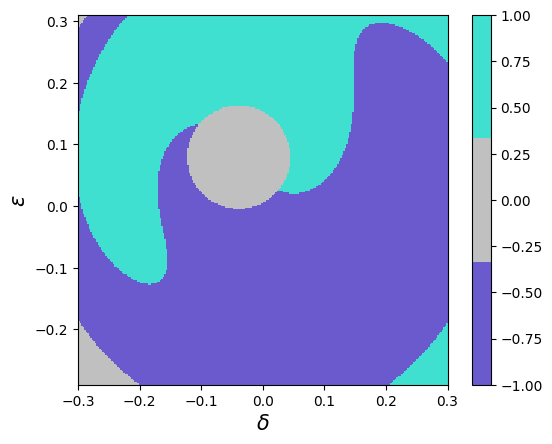

In [341]:
#PLOTTING DEFINITIVE 
with open('DEF eps vs delta,eps1=-eps2,a=5g=3par_res=0.0025.pkl', 'rb') as file:
    fil = pickle.load(file)
par_res=0.02
eps_range = np.arange(0.31,-0.3,-par_res)
d_range = np.arange(-0.3,0.31,par_res) 
print(len(d_range),len(eps_range))
csfont = {'fontname':'Serif'}
x,y = d_range, eps_range 
grid=np.real(np.round(fil))

# Create a new figure and add a subplot
fig, ax = plt.subplots()

# Define colors manually
colors = ['slateblue', 'silver','turquoise']  # Add more colors as needed

# Create a ListedColormap with the specified colors
cmap = ListedColormap(colors)

cax= plt.imshow(grid, extent=(x.min(), x.max(), y.min(), y.max()),
           interpolation='nearest',cmap=cmap)

fig.colorbar(cax)
#plt.title('eps1=0.5,eps2=0.5,d=0',**csfont)
plt.xlabel(r'$\delta$',**csfont,size=15)
h=0.29
#plt.xlim(-h,h)
#plt.ylim(-h,h)
plt.ylabel(r'$\epsilon$',**csfont,size=15)
plt.savefig("/mnt/c/Users/azorzat/OneDrive - UvA/Desktop/Plots Paper/Topo/DEFDEF a=5 g=3.pdf", bbox_inches='tight')  

In [335]:
#gap closing points


par_res=0.0025
eps_range = np.arange(0.31,-0.3,-par_res)
d_range = np.arange(-0.3,0.31,par_res) 
S = np.zeros((len(eps_range),len(d_range)), dtype='c16')
#trying original formula 

a,g=5,3
th=5e-3
eta=0

for m,eps in enumerate(tqdm(eps_range)):
    
    for n,d in enumerate(d_range):
        
        #compute eigenvalues in BZ
        eigvals0,_=np.linalg.eigh(H(0,a,g,eps,-eps,d,eta))
        eigvalspi,_=np.linalg.eigh(H(np.pi/2,a,g,eps,-eps,d,eta))
        order0=np.argsort(eigvals0)
       # print(eigvals0[order0][2],eigvals0[order0][1])
        if (eigvals0[2])<th:
            #print(np.abs(eigvals0[order0][2]+eigvals0[order0][1]))
            S[m,n]=1
        elif (eigvalspi[2])<th:
            #print(np.abs(eigvals0[order0][2]+eigvals0[order0][1]))
            S[m,n]=1
        else:
            continue
            
        
 #saving data
#with open('DEF eps vs delta,eps1=-eps2,a='+str(a)+'g='+str(g)+'par_res='+str(par_res)+'.pkl', 'wb') as file:
#        
#    # A new file will be created
#    pickle.dump(A1, file)   
#    



100%|█████████████████████████████████████████████████████████████████████████████████| 244/244 [00:04<00:00, 53.76it/s]


In [577]:
np.where(S==1)

(array([   0,    1,    2, ..., 1797, 1798, 1799]),
 array([0, 0, 0, ..., 0, 0, 0]))

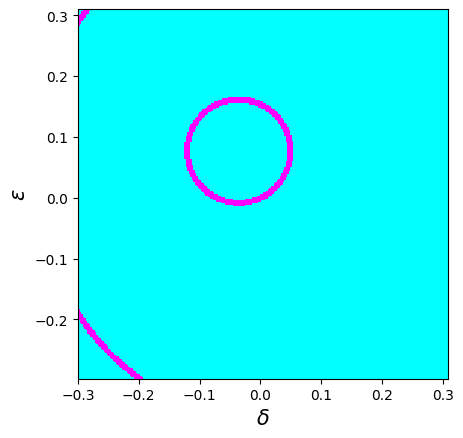

In [337]:
x,y =d_range,eps_range
grid=S.real

# Create a new figure and add a subplot
fig, ax = plt.subplots()


cax= plt.imshow(grid, extent=(x.min(), x.max(), y.min(), y.max()),
           interpolation='none',cmap='cool')

plt.xlabel(r'$\delta$',**csfont,size=15)
h=0.5
#plt.xlim(-h,h)
#plt.ylim(-h,h)
plt.ylabel(r'$\epsilon$',**csfont,size=15)
plt.savefig("/mnt/c/Users/azorzat/OneDrive - UvA/Desktop/Plots Paper/Topo/DEF gap a=5 g=3.pdf", bbox_inches='tight')  

In [329]:

k_range = np.arange(-np.pi,np.pi,0.001)
a,g=5,3
eps,d,eta=-0.25,-0.25,0
eps_range = np.arange(-2,2,0.1)
eigenvalues=np.zeros((len(k_range),4))


for i,k in enumerate(k_range):
    #print(i,k)
    #inverse = np.linalg.inv(H(k,1,1,eps,eps,d))
    eigvals,_=np.linalg.eigh(H(k,a,g,eps,-eps,d,eta))
    #print(eigvals)
    eigenvalues[i,:]=eigvals#[np.argsort(eigvals)]
    #eigenvectors[i,:]=eigvecs

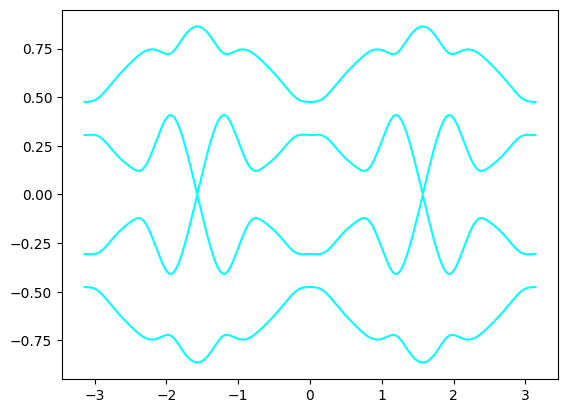

In [330]:
from itertools import cycle
colormap1 = plt.cm.cool
color_cycle1 = cycle(colormap1(np.linspace(0, 1, len(eps_range))))
   
color1 = next(color_cycle1)
plt.plot(k_range,eigenvalues,c=color1)
#plt.plot(k_range,-eigenvalues)
h=4
#plt.xlim(-np.pi,np.pi)
#plt.ylim(-h,h)
#print(inverse)

In [336]:
#ph index Riemann            
k_res=0.001
par_res=0.12
eps_range = np.arange(-0.6,0.7,par_res)
d_range = np.arange(-0.6,0.9,par_res) 
k_range = np.arange(-np.pi, np.pi, k_res)

eps,d,eta=0,0,0
#trying original formula 
A4 = np.zeros((len(eps_range),len(d_range)), dtype='c16')

for m,a in enumerate(tqdm(eps_range)):
    
    for n,g in enumerate(d_range):
        
        v=np.zeros(len(k_range),dtype='c16')
        
        for i,k in enumerate(k_range):
            
            
            inv = (np.linalg.inv(H(k,a,g,eps,eps,d,eta)))
            der = (1/(2*k_res))*(H(k+k_res,a,g,eps,eps,d,eta)-H(k-k_res,a,g,eps,eps,d,eta))
            temp = C2@inv@der
            v[i]= np.trace(temp)
           
        
        v_tot=(k_res)*(1/(4*np.pi*1j))*np.sum(v,axis=0)  
        
    A4[m,n]=v_tot

 45%|██████████████████████████████████████▏                                             | 5/11 [00:47<00:57,  9.52s/it]/tmp/ipykernel_3890/1003602808.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  N1=((1/np.cosh(G/2))**(4))*(-8*np.cosh(G/2)**(3)-4*np.sinh(G/2)**(2)*np.cos(3*k)+2*(3*np.cosh(G)+1)*np.cos(k))/(8*A) -eps1+d*np.cos(3*k)#checked
/tmp/ipykernel_3890/1003602808.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  N2=(-((1/np.cosh(G/2))**(4))/(4*A))*(4*np.cosh(G/2)**(3)-2*np.sinh(G/2)**(2)*np.cos(3*k)+3*np.cosh(G)*np.cos(k)+np.cos(k)) -eps2-d*np.cos(3*k) #checked
/tmp/ipykernel_3890/1003602808.py:14: RuntimeWarning: divide by zero encountered in cdouble_scalars
  Hm=-np.tanh(G/2)*((1/np.cosh(G/2))**(3)*(np.cosh(G)+4*1j*np.sinh(G/2)*np.sin(k)**(3)+2*np.cos(2*k)-1))/(2*A) +1j*d*np.sin(3*k)#checked
/tmp/ipykernel_3890/3085801860.py:22: RuntimeWarning: invalid value encountered in subtract
  der = (1/(2*k_res))*(H(k+k_res,a,g,eps,eps,d,eta)-

In [332]:
#ph index integrator
def integrand_ph(k,a,g,eps1,eps2,d,eta):
    inv = (np.linalg.inv(H(k,a,g,eps1,eps2,d,eta)))
    der = (1/(2*k_res))*(H(k+k_res,a,g,eps1,eps2,d,eta)-H(k-k_res,a,g,eps1,eps2,d,eta))
    temp = C2@inv@der
    return np.trace(temp)
     
k_res=0.001
par_res=0.05
eps_range = np.arange(-0.6,0.7,par_res)
d_range = np.arange(-0.6,0.9,par_res) 
k_range = np.arange(-np.pi, np.pi, k_res)

eps,d,eta=0,0,0
#trying original formula 
A3 = np.zeros((len(eps_range),len(d_range)), dtype='c16')

for m,a in enumerate(tqdm(eps_range)):
    
    for n,g in enumerate(d_range):

        try:
            # Attempt to evaluate the integral
            v_tot = complex_quadrature(lambda k: integrand_ph(k,a,g,eps,eps,d,eta), -np.pi, np.pi)

            # Normalize the result
            v_tot = (1 / (2 * np.pi * 1j)) * v_tot

            # Store the re   sult in the matrix
            A3[m, n] = v_tot

        except Exception as e:
            # Handle the exception (e.g., matrix is singular, integral diverges)
            print(f"Integration failed for ({eps}, {d}): {e}")
            
            # Assign a specific value to A1[m, n] when integration fails
            A3[m, n] = 13  # You can replace np.nan with any other value
           

100%|███████████████████████████████████████████████████████████████████████████████████| 26/26 [00:08<00:00,  3.16it/s]


In [320]:
#chiral index Riemann
k_res=0.001
eps_range = np.arange(-0.5,0.5,0.12)
d_range = np.arange(-0.5,0.5,0.12) 
k_range = np.arange(-np.pi, np.pi, k_res)

#trying original formula 
A1 = np.zeros((len(eps_range),len(d_range)), dtype='c16')
eps,d,eta=0,0,0
for m,a in enumerate(tqdm(eps_range)):
    
    for n,g in enumerate(d_range):
        
        v=np.zeros(len(k_range),dtype='c16')

        for i,k in enumerate(k_range):
            
            
            inv = (np.linalg.inv(magical(k,a,g,eps,eps,d,eta)))
            der = (1/(2*k_res))*(magical(k+k_res,a,g,eps,eps,d,eta)-magical(k-k_res,a,g,eps,eps,d,eta))
            temp = inv@der
            v[i]= np.trace(temp)
           
        v_tot=(k_res)*(1/(2*np.pi*1j))*np.sum(v,axis=0)  
   
        A1[m,n]=v_tot
    



100%|█████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:34<00:00, 10.45s/it]


In [249]:
#rotation business
k,a,g,eps1,eps2,d,eta=1,1,1,0,0,0,0
#H(k,A,G,eps1,eps2,d,eta)


U =expm(-1j*(np.pi/4)*np.kron(sigma_y,id))
G=np.diag([np.sqrt(1j),np.sqrt(1j),-np.sqrt(-1j),-np.sqrt(-1j)])

In [254]:
np.allclose((U@G)@H(k,a,g,eps1,eps2,d,eta)@(U@G).conj().T,(magic)@H(k,a,g,eps1,eps2,d,eta)@(magic).conj().T)

True

In [268]:
np.allclose(U@G, magic)

True

In [255]:
(U@G)@H(k,a,g,eps1,eps2,d,eta)@(U@G).conj().T

array([[-5.55111512e-17+2.77555756e-17j,  5.55111512e-17-4.16333634e-17j,
        -3.33394617e-01+6.53189746e-01j,  1.91511600e-01-5.30601145e-01j],
       [ 1.38777878e-17+3.46944695e-17j, -2.22044605e-16+0.00000000e+00j,
        -9.82989706e-02-1.30332585e-01j, -1.44024315e+00-6.53189746e-01j],
       [-3.33394617e-01-6.53189746e-01j, -9.82989706e-02+1.30332585e-01j,
         5.55111512e-17+0.00000000e+00j, -2.77555756e-17+4.85722573e-17j],
       [ 1.91511600e-01+5.30601145e-01j, -1.44024315e+00+6.53189746e-01j,
        -5.55111512e-17-5.55111512e-17j,  2.77555756e-16+0.00000000e+00j]])

In [257]:
np.allclose((U@G).conj().T,   G.conj().T@U.conj().T)

True

In [258]:
np.allclose(G.conj().T@U@G@H(k,a,g,eps1,eps2,d,eta)@G.conj().T@U.conj().T@G,G.conj().T@magical(k,a,g,eps1,eps2,d,eta)@G)

True

In [259]:
Y=G.conj().T@U@G

In [260]:
np.allclose(Y@H(k,a,g,eps1,eps2,d,eta)@Y.conj().T,G.conj().T@magical(k,a,g,eps1,eps2,d,eta)@G)

True

In [267]:
np.allclose(sigma_z@sigma_y,-1j*sigma_x)

True

In [266]:
sigma_z@sigma_y

array([[0.+0.j, 0.-1.j],
       [0.-1.j, 0.+0.j]])

In [271]:
np.allclose(np.linalg.inv(magical(k,a,g,eps1,eps2,d,eta)),magical(k,a,g,eps1,eps2,d,eta).conj().T)

False